In [28]:
!pip install -U layoutparser

Requirement already up-to-date: layoutparser in /usr/local/lib/python3.7/dist-packages (0.2.0)


In [29]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

In [30]:
!pip install layoutparser[ocr]     

In [31]:
!git clone https://github.com/Layout-Parser/layout-parser.git

Cloning into 'layout-parser'...
remote: Enumerating objects: 1034, done.
remote: Counting objects: 100% (540/540), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 1034 (delta 305), reused 428 (delta 213), pack-reused 494
Receiving objects: 100% (1034/1034), 63.67 MiB | 37.62 MiB/s, done.
Resolving deltas: 100% (534/534), done.


In [32]:
%cd layout-parser/

/content/layout-parser/layout-parser


In [33]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/paper-image.jpg")
image = image[..., ::-1] 

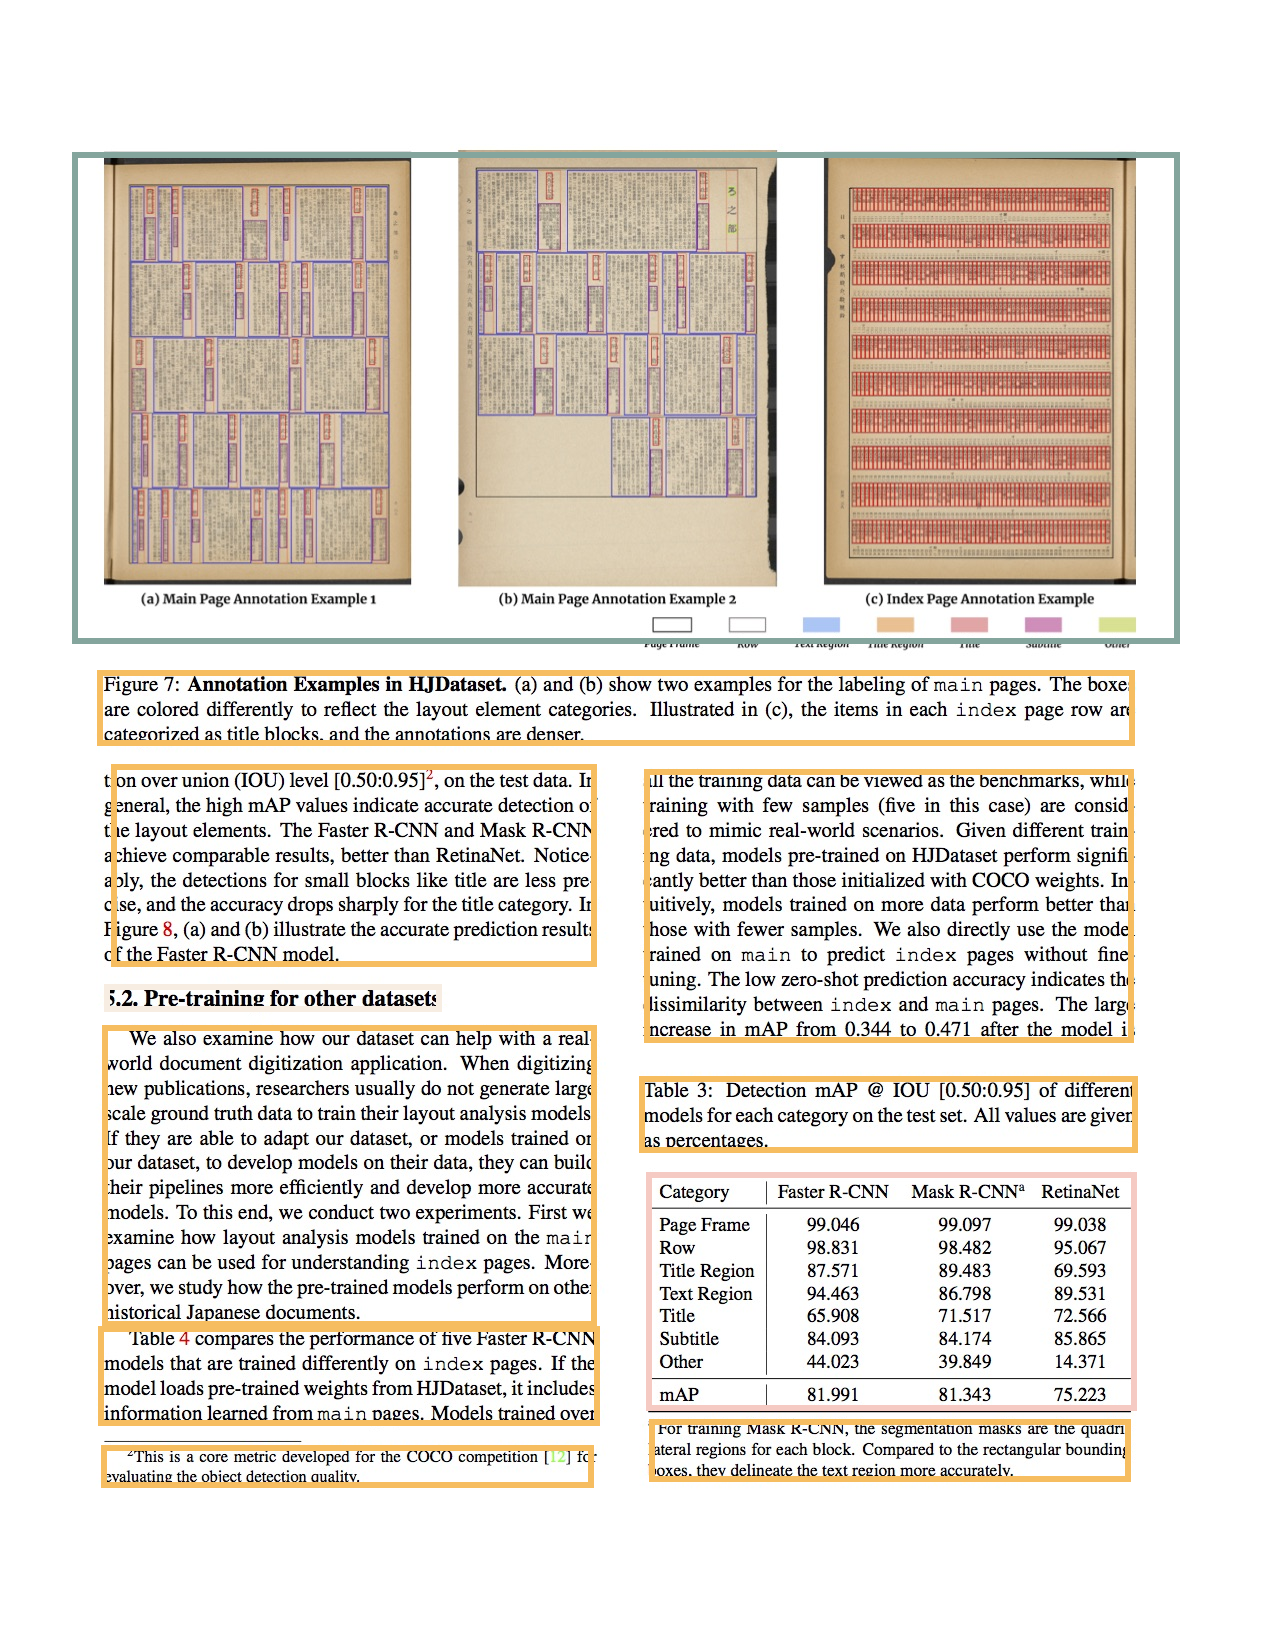

In [34]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [45]:
text_blocks = lp.Layout([b for b in layout if b.type=="Title"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=104.18392944335938, y_1=984.3191528320312, x_2=441.5095520019531, y_2=1011.412841796875), text=None, id=None, type=Title, parent=None, next=None, score=0.9871368408203125)], page_data={})

In [46]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [47]:
figure_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=72.328857421875, y_1=152.18548583984375, x_2=1179.62939453125, y_2=643.6030883789062), text=None, id=None, type=Figure, parent=None, next=None, score=0.9979682564735413)], page_data={})

In [48]:

text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [49]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

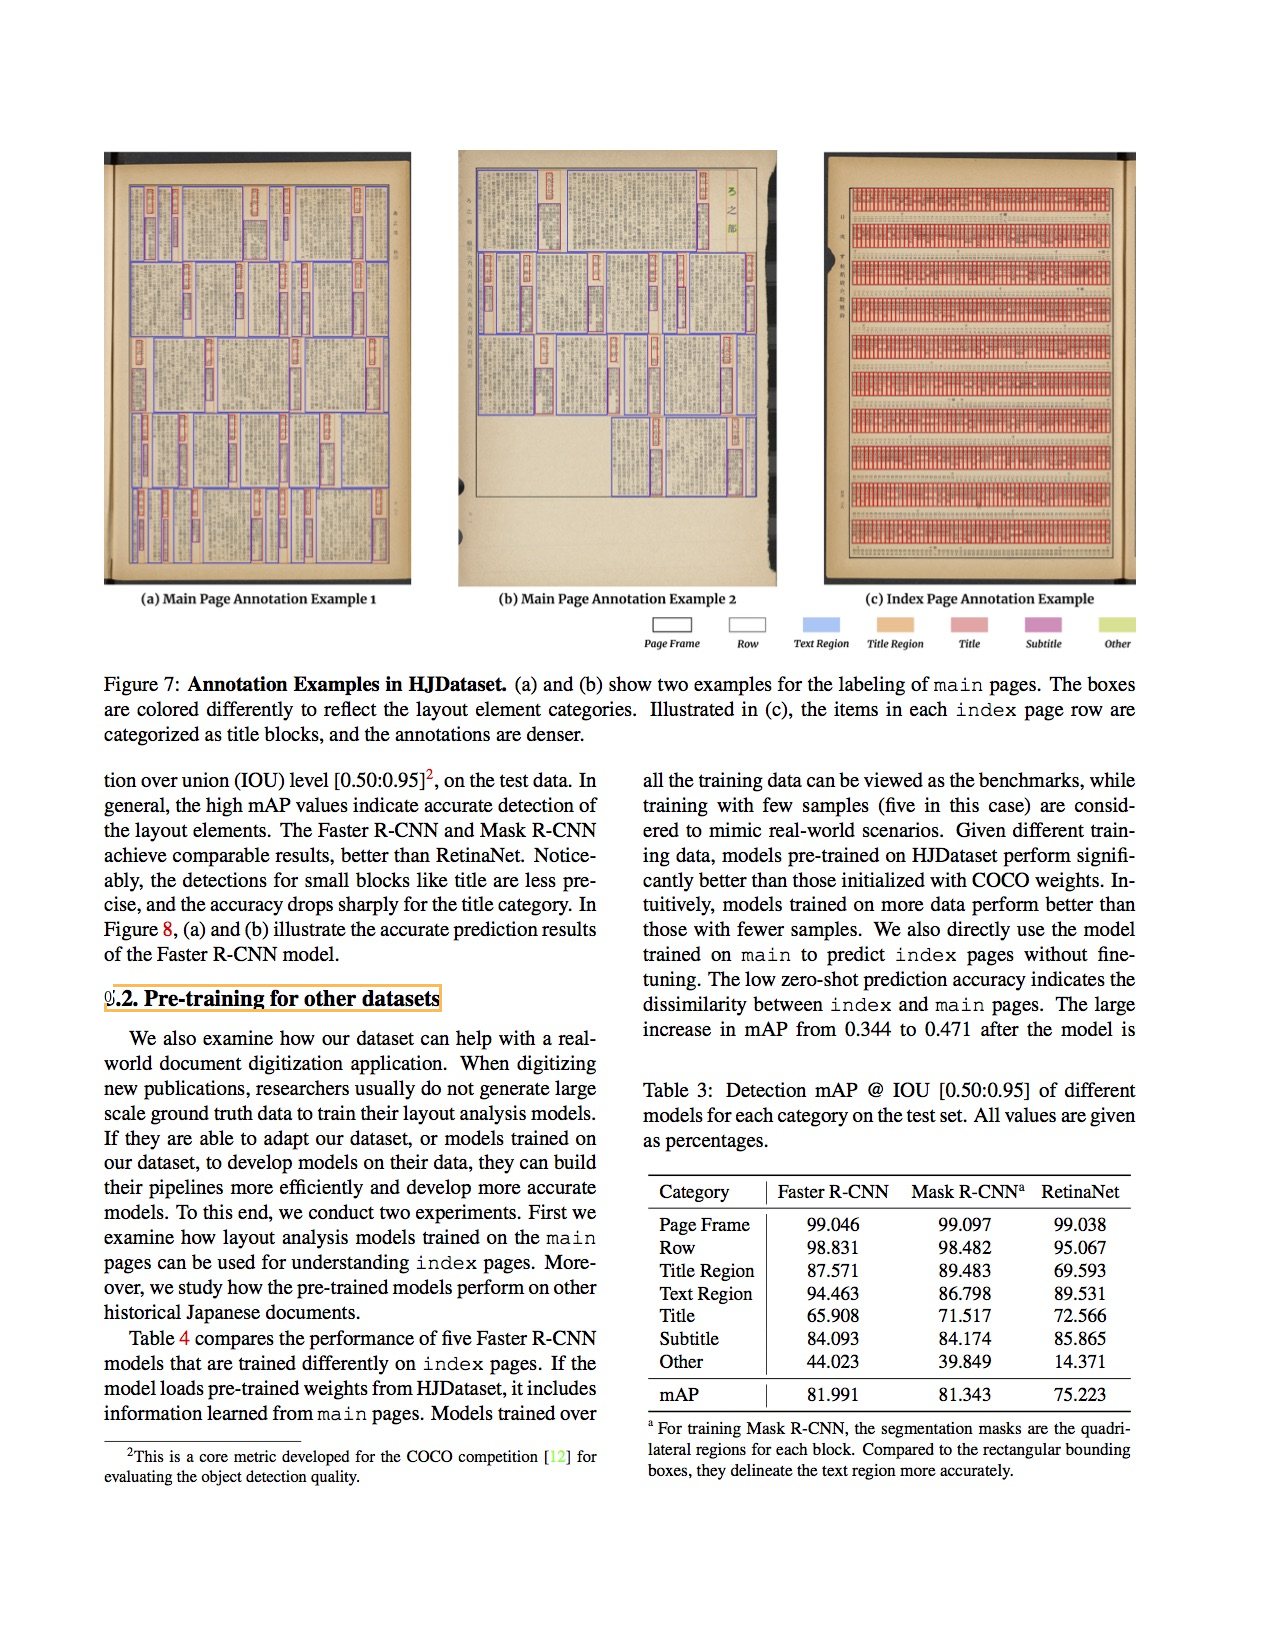

In [50]:

lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [52]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [53]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [54]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [55]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

5.2. Pre-training for other datasets

---


In [ ]:
text_blocks.get_texts()

In [ ]:
for block in text_blocks:
  print(block)

In [ ]:
!pip install spacy

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [ ]:
!pip install click==7.1.1

In [ ]:
import spacy
nlp = spacy.load("en_core_web_trf")


In [ ]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [ ]:
".".join(sentence)  

In [ ]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)